In [1]:
# If we are on colab: this clones the repo and installs the dependencies
from pathlib import Path

if Path.cwd().name != "LightGlue":
    !git clone --quiet https://github.com/cvg/LightGlue/
    %cd LightGlue
    !pip install --progress-bar off --quiet -e .

from lightglue import LightGlue, SuperPoint, DISK
from lightglue.utils import load_image, rbd
from lightglue import viz2d
import torch

torch.set_grad_enabled(False)
images = Path("data")

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # 'mps', 'cpu'

In [3]:
def extract_patches(image, keypoints, size=32):
    patches = []
    valid_keypoints = []  # To store keypoints for which patches are created

    # If image is in channels-first format, transpose it to channels-last
    if image.shape[0] < image.shape[1] and image.shape[0] < image.shape[2]:
        image = image.transpose(1, 2, 0)  # Convert to (H, W, C)
    
    for kp in keypoints:
        x, y = int(kp[0]), int(kp[1])
        if x - size // 2 < 0 or y - size // 2 < 0 or x + size // 2 > image.shape[1] or y + size // 2 > image.shape[0]:
            continue  # Skip if the patch would be out of image bounds

        # Extract patch and store the corresponding keypoint
        patch = image[y - size // 2:y + size // 2, x - size // 2:x + size // 2]
        patches.append(patch)
        valid_keypoints.append((x, y))

    return patches, valid_keypoints

In [4]:
import torch
from torch.optim import lr_scheduler
import torch.optim as optim
from torch.autograd import Variable

# from siamese.trainer import fit
import numpy as np
cuda = torch.cuda.is_available()

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

In [5]:
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models

In [6]:
class UNet(nn.Module):
    def __init__(self, output_size=128):
        super(UNet, self).__init__()

        # Encoder
        self.enc_conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=2, padding=1)  # Output: 32x32x64
        self.enc_conv2 = nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1)  # Output: 16x16x128
        self.max_pool = nn.MaxPool2d(kernel_size=2, stride=2)  # Output: 8x8x128
        self.enc_conv3 = nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1)  # Output: 4x4x256
        self.enc_conv4 = nn.Conv2d(256, 512, kernel_size=1, stride=1, padding=0)  # Output: 2x2x512

        # Decoder with dense layers for embedding
        self.fc1 = nn.Linear(512 * 2 * 2, output_size)

    def forward(self, x):
        # Encoder
        x = F.relu(self.enc_conv1(x))
        x = F.relu(self.enc_conv2(x))
        x = self.max_pool(x)
        x = F.relu(self.enc_conv3(x))
        x = self.max_pool(x)
        x = F.relu(self.enc_conv4(x))

        # Flatten for the fully connected layers
        x = x.view(x.size(0), -1)

        # Decoder with dense layers for embedding
        x = self.fc1(x)

        return x

In [7]:
class SiameseNetwork(nn.Module):
    def __init__(self, embedding_net):
        super(SiameseNetwork, self).__init__()
        self.embedding_net = embedding_net

    def forward(self, x1, x2):
        output1 = self.get_embedding(x1)
        output2 = self.get_embedding(x2)
        return output1, output2

    def get_embedding(self, x):
        return self.embedding_net(x)


In [8]:
from torch.optim.lr_scheduler import StepLR

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(device)
embedding_net = UNet().to(device)
model = SiameseNetwork(embedding_net).to(device)

cuda


In [35]:
model_state_file = "miccai/Case096/model_weights-mr_us-64_256-all.pth"
model.load_state_dict(torch.load(model_state_file))
model.eval()

SiameseNetwork(
  (embedding_net): UNet(
    (enc_conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (enc_conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (max_pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (enc_conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (enc_conv4): Conv2d(256, 512, kernel_size=(1, 1), stride=(1, 1))
    (fc1): Linear(in_features=2048, out_features=128, bias=True)
  )
)

In [36]:
def convert_to_displayable_image(image):
    # Convert from tensor to NumPy if needed
    if torch.is_tensor(image):
        image = image.cpu().detach().numpy()
    
    # If image is float32, scale to [0, 255] and convert to uint8
    if image.dtype == np.float32:
        image = (image * 255).astype(np.uint8)
    
    # If image is in channels-first format, convert to channels-last
    if image.ndim == 3 and image.shape[0] in [1, 3]:
        image = image.transpose(1, 2, 0)  # Convert CxHxW to HxWxC

    return Image.fromarray(image)

#### Method to extract patches from image based on keypoints

In [37]:
def extract_patches(image, keypoints, size=32):
    patches = []
    valid_keypoints = []  # To store keypoints for which patches are created

    # If image is in channels-first format, transpose it to channels-last
    if image.shape[0] < image.shape[1] and image.shape[0] < image.shape[2]:
        image = image.transpose(1, 2, 0)  # Convert to (H, W, C)
    
    for kp in keypoints:
        x, y = int(kp[0]), int(kp[1])
        if x - size // 2 < 0 or y - size // 2 < 0 or x + size // 2 > image.shape[1] or y + size // 2 > image.shape[0]:
            continue  # Skip if the patch would be out of image bounds

        # Extract patch and store the corresponding keypoint
        patch = image[y - size // 2:y + size // 2, x - size // 2:x + size // 2]
        patches.append(patch)
        valid_keypoints.append((kp[0], kp[1]))

    return patches, valid_keypoints

In [38]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.patches import ConnectionPatch
import matplotlib.colors as mcolors
import numpy as np

%matplotlib inline
# Can only be used with a display
# %matplotlib notebook
# matplotlib.use('TkAgg')

patch_size=64

def show_matched_keypoints(image1, image2, good_kpts1, good_kpts2, bad_kpts1, bad_kpts2):
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))

    # Convert images to displayable format
    image1_np = image1.cpu().numpy().transpose(1, 2, 0)
    image2_np = image2.cpu().numpy().transpose(1, 2, 0)

    print(image1_np.shape)
    print(image2_np.shape)

    # Display original images
    axs[0].imshow(image1_np)
    axs[1].imshow(image2_np)

    # Overlay patches on images
    for i in range(len(good_kpts1)):
        x1, y1 = good_kpts1[i]
        x2, y2 = good_kpts2[i]
        color = 'lime'
        cir1 = patches.Circle((x1, y1), 1, linewidth=1, edgecolor=color, facecolor=color, alpha=1)
        cir2 = patches.Circle((x2, y2), 1, linewidth=1, edgecolor=color, facecolor=color, alpha=1)
        axs[0].add_patch(cir1)
        axs[1].add_patch(cir2)

        # Draw a line connecting the patches
        line = ConnectionPatch(xyA=(x1, y1), xyB=(x2, y2), coordsA='data', coordsB='data', axesA=axs[0], axesB=axs[1], color=color, alpha=0.5, linewidth=1.0)
        axs[1].add_artist(line)

    for i in range(len(bad_kpts1)):
        x1, y1 = bad_kpts1[i]
        x2, y2 = bad_kpts2[i]
        color = 'red'
        cir1 = patches.Circle((x1, y1), 1, linewidth=1, edgecolor=color, facecolor=color, alpha=1)
        cir2 = patches.Circle((x2, y2), 1, linewidth=1, edgecolor=color, facecolor=color, alpha=1)
        axs[0].add_patch(cir1)
        axs[1].add_patch(cir2)

        # Draw a line connecting the patches
        line = ConnectionPatch(xyA=(x1, y1), xyB=(x2, y2), coordsA='data', coordsB='data', axesA=axs[0], axesB=axs[1], color=color, alpha=0.5, linewidth=1.0)
        axs[1].add_artist(line)

    plt.savefig("lg_ours_slice_match.png")
    plt.show()


In [39]:
def add_batch_dimension(data: dict) -> dict:
    """Add batch dimension to elements in data"""
    return {
        k: v.unsqueeze(0) if isinstance(v, torch.Tensor) else
           np.expand_dims(v, 0) if isinstance(v, np.ndarray) else
           [v] if isinstance(v, list) else v
        for k, v in data.items()
    }

In [40]:
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch
from imageio import imread
import numpy as np

def load_path_for_pytorch(path, max_side=1000, force_scale=False, verbose=True):

    com_f = max

    x = imread(path)
    s = x.shape

    x = x/255.#-0.5
    xt = x.copy()
    
    if len(s) < 3:
        x = np.stack([x,x,x],2)

    if x.shape[2] > 3:
        x = x[:,:,:3]

    x = x.astype(np.float32)
    x = torch.from_numpy(x).contiguous().permute(2,0,1).contiguous()


    if (com_f(s[:2])>max_side and max_side>0) or force_scale:


        fac = float(max_side)/com_f(s[:2])
        x = F.interpolate(x.unsqueeze(0),( int(s[0]*fac), int(s[1]*fac) ), mode='bilinear', align_corners=False)[0]
        so = s
        s = x.shape

    return x

In [41]:
import torch
from PIL import Image
from torchvision.transforms import Resize, ToTensor

def isolate_green_and_mask_image(image_path, mask_path, long_side, device):
    
    # Load the images
    image = load_path_for_pytorch(image_path, long_side, force_scale=True)
    mask = load_path_for_pytorch(mask_path, long_side, force_scale=True)

    # Convert to tensor
    # to_tensor = ToTensor()
    image = image.to(device)
    mask = mask.to(device)

    # Isolate the green channel and create a binary mask
    # Assuming green regions have higher green values compared to red and blue
    green_channel = mask[1, :, :]
    red_channel = mask[0, :, :]
    blue_channel = mask[2, :, :]
    binary_mask = (green_channel > red_channel) & (green_channel > blue_channel)
    binary_mask = binary_mask.float()

    kernel_size = 11  # This corresponds to reducing the ROI by 5 pixels in each direction
    kernel = np.ones((kernel_size, kernel_size), np.uint8)

    # Apply erosion to reduce the ROI
    eroded_mask = cv2.erode(binary_mask.cpu().numpy(), kernel, iterations=1)

    # Apply the mask
    masked_image = image * torch.from_numpy(eroded_mask).unsqueeze(0).to(device)

    return masked_image, binary_mask

/tmp/ipykernel_13772/3428403937.py:12: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  x = imread(path)


All Matches: 48
TPs: 35
FPs: 13
TPR: 72.91666666666666%
FPR: 27.083333333333332%
(192, 192, 3)
(192, 192, 3)


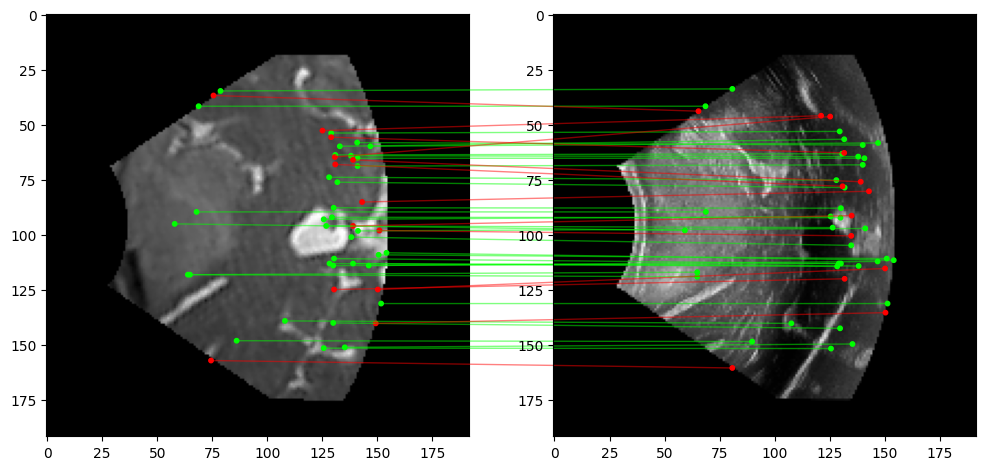

In [44]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms
import cv2

# Function to get embeddings for a list of patches
def get_embeddings(patches):
    embeddings = []
    # print(patches)
    for patch in patches:
        patch_processed = preprocess_image(patch).unsqueeze(0).to(device)  # Add batch dimension
        with torch.no_grad():
            embedding = model.get_embedding(patch_processed)
        embeddings.append(embedding.cpu().numpy())
    return np.vstack(embeddings)


def extract_and_match_patches(image1, kpts1, image2, model, extractor, device, patch_size=64, top_k=5):
    # Preprocess and extract patches from both images
    image1 = image1.to(device)
    image2 = image2.to(device)

    extractor = SuperPoint(max_num_keypoints=None).eval().to(device)  # load the extractor
    
    feats2 = extractor.extract(image2)
    feats2 = rbd(feats2)
    kpts2 = feats2["keypoints"]

    # Extract patches from both images
    # Enforce keypoints on both images
    # kpts2 = kpts1
    
    patches1, kpts1 = extract_patches(image1.cpu().numpy(), kpts1.cpu().numpy(), size=patch_size)
    patches2, kpts2 = extract_patches(image2.cpu().numpy(), kpts2.cpu().numpy(), size=patch_size)

    # Get embeddings for patches from both images
    embeddings1 = get_embeddings(patches1)
    embeddings2 = get_embeddings(patches2)

    matcher = LightGlue(features="disk").eval().to(device)

    feats1 = {}
    feats2 = {}

    feats1['keypoints'] = torch.tensor(kpts1).to(device)
    feats2['keypoints'] = torch.tensor(kpts2).to(device)
    feats1['descriptors'] = torch.tensor(embeddings1).to(device)
    feats2['descriptors'] = torch.tensor(embeddings2).to(device)
    feats1['image'] = image1
    feats2['image'] = image2

    #Add back the batch dimension
    feats1 = add_batch_dimension(feats1)
    feats2 = add_batch_dimension(feats2)

    matches12 = matcher({"image0": feats1, "image1": feats2})
    
    feats1, feats2, matches12 = [
        rbd(x) for x in [feats1, feats2, matches12]
    ]

    kpts1, kpts2, matches = feats1["keypoints"], feats2["keypoints"], matches12["matches"]

    m_kpts1, m_kpts2 = kpts1[matches[..., 0]], kpts2[matches[..., 1]]

    all_matches = len(m_kpts1)
    print(f"All Matches: {all_matches}") 

    # Extract patches from both images
    patches1, m_kpts1 = extract_patches(image1.cpu().numpy(), m_kpts1.cpu().numpy(), size=patch_size)
    patches2, m_kpts2 = extract_patches(image2.cpu().numpy(), m_kpts2.cpu().numpy(), size=patch_size)
    
    good_kpts1, good_kpts2, good_patches1, good_patches2, bad_kpts1, bad_kpts2, bad_patches1, bad_patches2, similar_patches_count = extract_good_and_bad_matches(patches1, patches2, m_kpts1, m_kpts2)
    
    print(f"TPs: {len(good_kpts1)}")
    print(f"FPs: {len(bad_kpts1)}")
    print(f"TPR: {len(good_kpts1)/all_matches*100}%")
    print(f"FPR: {len(bad_kpts1)/all_matches*100}%")

    show_matched_keypoints(image1, image2, good_kpts1, good_kpts2, bad_kpts1, bad_kpts2)
    
    return patches1, patches2, kpts1, kpts2, good_patches1, good_patches2, good_kpts1, good_kpts2, bad_patches1, bad_patches2, bad_kpts1, bad_kpts2

# Extract good and bad matches from the patches based on a margin:
def extract_good_and_bad_matches(good_patches1, good_patches2, good_kpts1, good_kpts2, margin=4):
    count = 0
    
    good_good_kpts1 = []
    good_good_kpts2 = []
    good_good_patches1 = []
    good_good_patches2 = []
    
    bad_good_kpts1 = []
    bad_good_kpts2 = []
    bad_good_patches1 = []
    bad_good_patches2 = []
    
    
    for i in range(len(good_kpts1)):
        # Get keypoints from both images
        kp1 = good_kpts1[i]
        kp2 = good_kpts2[i]

        # Check if keypoints are within the margin
        if (abs(kp1[0] - kp2[0]) <= margin) and (abs(kp1[1] - kp2[1]) <= margin):
            good_good_kpts1.append(kp1)
            good_good_kpts2.append(kp2)
            good_good_patches1.append(good_patches1[i])
            good_good_patches2.append(good_patches2[i])
            count += 1
        else:
            bad_good_kpts1.append(kp1)
            bad_good_kpts2.append(kp2)
            bad_good_patches1.append(good_patches1[i])
            bad_good_patches2.append(good_patches2[i])

    return good_good_kpts1, good_good_kpts2, good_good_patches1, good_good_patches2, bad_good_kpts1, bad_good_kpts2, bad_good_patches1, bad_good_patches2, count

def preprocess_image(image):
    # Implement any preprocessing steps (resizing, normalization, etc.)
    transform = transforms.Compose([
        transforms.ToTensor(),  # Converts image to PyTorch tensor in CxHxW format
        transforms.Normalize(mean=(0), std=(1))  # Normalize the image
    ])
    image = transform(image).to(device)
    return image

# Example usage
# image1 = load_image('data/real/anchor.png')
# image2 = load_image('data/real/real.png')

long_side = 192

image1 = load_path_for_pytorch("data/mr_us/Case096/t2/035.png", long_side,force_scale=True).to(device)
# image2 = load_path_for_pytorch("data/miccai/cam/case207/cat5_1.0.png", long_side,force_scale=True).to(device)
image2 = load_path_for_pytorch("data/mr_us/Case096/us/035.png", long_side,force_scale=True).to(device)

masked_image1, binary_mask = isolate_green_and_mask_image(images/f"mr_us/Case096/t2/035.png", images/"mr_us/Case096/us_mask.png", long_side, device)

extractor = SuperPoint(max_num_keypoints=None).eval().to(device)  # load the extractor

image1 = image1.to(device)
feats1 = extractor.extract(image1)
feats1 = rbd(feats1)
kpts1 = feats1["keypoints"]

patches1, patches2, kpts1, kpts2, good_patches1, good_patches2, good_kpts1, good_kpts2, bad_patches1, bad_patches2, bad_kpts1, bad_kpts2 = extract_and_match_patches(image1, kpts1, image2, model, extractor, device)

In [26]:
def extract_and_match_patches_all(image1, kpts1, image2, model, extractor, device, patch_size=64, top_k=5):
    # Preprocess and extract patches from both images
    image1 = image1.to(device)
    image2 = image2.to(device)

    extractor = SuperPoint(max_num_keypoints=None).eval().to(device)  # load the extractor
    
    feats2 = extractor.extract(image2)
    feats2 = rbd(feats2)
    kpts2 = feats2["keypoints"]

    # Extract patches from both images
    # Enforce keypoints on both images
    # kpts2 = kpts1
    
    patches1, kpts1 = extract_patches(image1.cpu().numpy(), kpts1.cpu().numpy(), size=patch_size)
    patches2, kpts2 = extract_patches(image2.cpu().numpy(), kpts2.cpu().numpy(), size=patch_size)

    # Get embeddings for patches from both images
    embeddings1 = get_embeddings(patches1)
    embeddings2 = get_embeddings(patches2)

    matcher = LightGlue(features="disk").eval().to(device)

    feats1 = {}
    feats2 = {}

    feats1['keypoints'] = torch.tensor(kpts1).to(device)
    feats2['keypoints'] = torch.tensor(kpts2).to(device)
    feats1['descriptors'] = torch.tensor(embeddings1).to(device)
    feats2['descriptors'] = torch.tensor(embeddings2).to(device)
    feats1['image'] = image1
    feats2['image'] = image2

    #Add back the batch dimension
    feats1 = add_batch_dimension(feats1)
    feats2 = add_batch_dimension(feats2)

    matches12 = matcher({"image0": feats1, "image1": feats2})
    
    feats1, feats2, matches12 = [
        rbd(x) for x in [feats1, feats2, matches12]
    ]

    kpts1, kpts2, matches = feats1["keypoints"], feats2["keypoints"], matches12["matches"]

    m_kpts1, m_kpts2 = kpts1[matches[..., 0]], kpts2[matches[..., 1]]

    all_matches = len(m_kpts1)
    print(f"All Matches: {all_matches}") 

    # Extract patches from both images
    patches1, m_kpts1 = extract_patches(image1.cpu().numpy(), m_kpts1.cpu().numpy(), size=patch_size)
    patches2, m_kpts2 = extract_patches(image2.cpu().numpy(), m_kpts2.cpu().numpy(), size=patch_size)
    
    good_kpts1, good_kpts2, good_patches1, good_patches2, bad_kpts1, bad_kpts2, bad_patches1, bad_patches2, similar_patches_count = extract_good_and_bad_matches(patches1, patches2, m_kpts1, m_kpts2)
    
    print(f"TPs: {len(good_kpts1)}")
    print(f"FPs: {len(bad_kpts1)}")
    print(f"TPR: {len(good_kpts1)/all_matches*100}%")
    print(f"FPR: {len(bad_kpts1)/all_matches*100}%")
    
    return all_matches, len(good_kpts1), len(bad_kpts1), len(good_kpts1)/all_matches*100, len(bad_kpts1)/all_matches*100

In [27]:
import numpy as np

# Metrics accumulators
total_matches = 0
total_tps = 0
total_fps = 0
total_tpr = 0
total_fpr = 0
slice_count = 78

for i in range(slice_count):
    slice_num = f"{i:03}.png"  # Format the slice number with leading zeros
    t2_path = f"data/mr_us/Case067/t2/{slice_num}"
    us_path = f"data/mr_us/Case067/us/{slice_num}"
    
    # Load images (modify your load_path_for_pytorch function accordingly)
    image1 = load_path_for_pytorch(t2_path, long_side, force_scale=True).to(device)
    image2 = load_path_for_pytorch(us_path, long_side, force_scale=True).to(device)
    
    # You might need to adjust how keypoints are loaded and processed based on your specific setup
    # masked_image1, binary_mask = isolate_green_and_mask_image(images/f"mr_us/Case096/t2/{slice_num}", images/"mr_us/Case096/us_mask.png", long_side, device)

    # plt.imshow(masked_image1.cpu().numpy().transpose(1,2,0))

    extractor = SuperPoint(max_num_keypoints=None).eval().to(device)
    # image1 = image1.to(device)
    feats1 = extractor.extract(image1)
    feats1 = rbd(feats1)
    kpts1 = feats1["keypoints"]

    print(f"Slice Number: {i}")
    # Perform matching
    all_matches, tps, fps, tpr, fpr = extract_and_match_patches_all(image1, kpts1, image2, model, extractor, device)
    
    # Accumulate metrics
    total_matches += all_matches
    total_tps += tps
    total_fps += fps
    total_tpr += tpr
    total_fpr += fpr

# Compute averages
avg_matches = total_matches / slice_count
avg_tps = total_tps / slice_count
avg_fps = total_fps / slice_count
avg_tpr = total_tpr / slice_count
avg_fpr = total_fpr / slice_count

print(f"Average Matches: {avg_matches}")
print(f"Average TPs: {avg_tps}")
print(f"Average FPs: {avg_fps}")
print(f"Average TPR: {avg_tpr}%")
print(f"Average FPR: {avg_fpr}%")


/tmp/ipykernel_22451/3428403937.py:12: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  x = imread(path)


Slice Number: 0
All Matches: 20
TPs: 6
FPs: 14
TPR: 30.0%
FPR: 70.0%
Slice Number: 1
All Matches: 12
TPs: 2
FPs: 10
TPR: 16.666666666666664%
FPR: 83.33333333333334%
Slice Number: 2
All Matches: 22
TPs: 7
FPs: 15
TPR: 31.818181818181817%
FPR: 68.18181818181817%
Slice Number: 3
All Matches: 12
TPs: 3
FPs: 9
TPR: 25.0%
FPR: 75.0%
Slice Number: 4
All Matches: 10
TPs: 1
FPs: 9
TPR: 10.0%
FPR: 90.0%
Slice Number: 5
All Matches: 28
TPs: 14
FPs: 14
TPR: 50.0%
FPR: 50.0%
Slice Number: 6
All Matches: 37
TPs: 17
FPs: 20
TPR: 45.94594594594595%
FPR: 54.054054054054056%
Slice Number: 7
All Matches: 27
TPs: 9
FPs: 18
TPR: 33.33333333333333%
FPR: 66.66666666666666%
Slice Number: 8
All Matches: 13
TPs: 7
FPs: 6
TPR: 53.84615384615385%
FPR: 46.15384615384615%
Slice Number: 9
All Matches: 23
TPs: 10
FPs: 13
TPR: 43.47826086956522%
FPR: 56.52173913043478%
Slice Number: 10
All Matches: 11
TPs: 3
FPs: 8
TPR: 27.27272727272727%
FPR: 72.72727272727273%
Slice Number: 11
All Matches: 18
TPs: 7
FPs: 11
TPR: 38.

### Show matched patches side by side
Patches from original image are shown side by side with the top matched patch in the stylized image

In [18]:
# import torch
# import numpy as np
# import matplotlib.pyplot as plt
# from torchvision.transforms.functional import to_pil_image

# def plot_matched_patches(patches1, patches2, top_matches, match_indexes, distances):
#     # Iterate over each patch in patches1
#     count = 0
#     for i, patch1 in enumerate(patches1):
#         if i >= len(top_matches) or len(top_matches[i]) == 0 or match_indexes.get(i) is None:
#             continue  # Skip if no matches
#         # Get the top match for patch1
#         match_idx = top_matches[i][0]
#         distance = distances[i][0]
#         patch2 = patches2[match_idx]

#         # Create a subplot for each pair of patches
#         fig, axs = plt.subplots(1, 2, figsize=(6, 3))
#         axs[0].imshow(patch1)
#         axs[0].set_title(f"Original Patch\nIndex: {count}")
#         axs[0].axis('off')
        
#         axs[1].imshow(patch2)
#         axs[1].set_title(f"Matched Patch\nDistance: {distance:.2f}")
#         axs[1].axis('off')

#         plt.show()
#         count+=1


# def extract_and_match_selected_patches(image1, image2, patches1, patches2, kpts1, kpts2, top_matches, distances):

#     # Extract good and bad matches
#     good_matches, bad_matches, count = extract_good_and_bad_matches(kpts1, kpts2, top_matches, margin=15)

#     filtered_top_matches = [top_match for top_match in top_matches if len(top_match) != 0]
    
#     print(f"All Matches (within threshold): {len(filtered_top_matches)}")
#     print(f"Good Matches: {len(good_matches)}")
#     print(f"Bad Matches: {len(bad_matches)}")
#     print(f"Percentage of Good Matches: {(len(good_matches)/len(filtered_top_matches))*100}%")

#     # Plot bad matches
#     print("Plotting bad matches:")
#     plot_matched_patches(patches1, patches2, top_matches, bad_matches, distances)

# extract_and_match_selected_patches(image1, image2, patches1, patches2, kpts1, kpts2, top_matches, distances)

In [19]:
# import torch
# import numpy as np
# import matplotlib.pyplot as plt
# from torchvision.transforms.functional import to_pil_image

# def plot_matched_patches(patches1, patches2, distances):
#     # Iterate over each patch in patches1
#     count = 0
#     for i in range(len(patches1)):
#         # Get the top match for patch1
#         patch1 = patches1[i]
#         patch2 = patches2[i]
#         distance = distances[i]

#         # Create a subplot for each pair of patches
#         fig, axs = plt.subplots(1, 2, figsize=(6, 3))
#         axs[0].imshow(patch1)
#         axs[0].set_title(f"Original Patch\nIndex: {count}")
#         axs[0].axis('off')
        
#         axs[1].imshow(patch2)
#         axs[1].set_title(f"Matched Patch\nDistance: {distance[0]:.2f}")
#         axs[1].axis('off')

#         plt.show()
#         count+=1



# plot_matched_patches(good_patches1, good_patches2, good_distances)
# # plot_matched_patches(bad_good_patches1, bad_good_patches2, bad_good_distances)

### Line Chart Plot of Good Matches (Select Index)
Plot a select index of good match against all the patches in the second image, y-axis has distances, x-axis has index of patch in patches2
Top match and second best match shown below the chart.

In [20]:
# import torch
# import numpy as np
# import matplotlib.pyplot as plt


# def extract_and_match_single_patch(image1, image2, patches1, patches2, kpts1, kpts2, top_matches, good_matches, distances):
#     # Filter patches in patches1 based on top_matches
#     patches_with_good_matches = [patches1[i] for i in good_matches.keys()]
    
#     matched_embeddings1 = get_embeddings(patches_with_good_matches)    
#     embeddings2 = get_embeddings(patches2)
    
#     selected_patch_index=7
#     # Select a patch from image1
#     selected_patch_embedding = matched_embeddings1[selected_patch_index]
#     # Calculate distances between selected patch and all patches in image2
#     distances = [np.linalg.norm(selected_patch_embedding - emb) for emb in embeddings2]
#     # Find the top two matches
#     top_two_matches = np.argsort(distances)[:2]
#     # Plot the distances
#     plot_patch_distances(selected_patch_index, distances, 'green', patches1, patches2, top_two_matches)


# def plot_patch_distances(selected_patch_index, distances, color, patches_with_good_matches, patches2, top_two_matches):
#     plt.figure(figsize=(12, 6))
#     plt.plot(distances, linewidth=1, color=color)
#     plt.xlabel('Patch Index in Image2')
#     plt.ylabel(f'Distance to Patch {selected_patch_index} in Image1')
#     plt.title(f'Distances from Patch {selected_patch_index} in Image1 to All Patches in Image2')
#     plt.grid()

#     # Display the selected patch and top two matches
#     fig, axs = plt.subplots(1, 3, figsize=(12, 3))
#     axs[0].imshow(patches1[selected_patch_index])
#     axs[0].set_title(f'Patch {selected_patch_index} in Image1')
#     axs[1].imshow(patches2[top_two_matches[0]])
#     axs[1].set_title(f'Top Match 1 in Image2')
#     axs[2].imshow(patches2[top_two_matches[1]])
#     axs[2].set_title(f'Top Match 2 in Image2')
#     for ax in axs:
#         ax.axis('off')
        
#     plt.show()

# extract_and_match_single_patch(image1, image2, patches1, patches2, kpts1, kpts2, top_matches, good_matches, distances)

In [21]:
# import torch
# import numpy as np
# import matplotlib.pyplot as plt


# def extract_and_match_single_patch(image1, image2, patches1, patches2, good_patches1, good_patches2, good_distances):
#     # Filter patches in patches1 based on top_matches
#     # patches_with_good_matches = [patches1[i] for i in good_matches.keys()]
    
#     embeddings1 = get_embeddings(good_patches1)    
#     embeddings2 = get_embeddings(patches2)
    
#     selected_patch_index=66
#     # Select a patch from image1
#     selected_patch_embedding = embeddings1[selected_patch_index]
#     # Calculate distances between selected patch and all patches in image2
#     distances = [np.linalg.norm(selected_patch_embedding - emb) for emb in embeddings2]
#     # Find the top two matches
#     top_two_matches = np.argsort(distances)[:2]
#     # print(top_two_matches)
#     # Plot the distances
#     plot_patch_distances(selected_patch_index, distances, 'green', good_patches1, patches2, top_two_matches)


# def plot_patch_distances(selected_patch_index, distances, color, patches1, patches2, top_two_matches):
#     plt.figure(figsize=(12, 6))
#     plt.plot(distances, linewidth=1, color=color)
#     plt.xlabel('Patch Index in Image2')
#     plt.ylabel(f'Distance to Patch {selected_patch_index} in Image1')
#     plt.title(f'Distances from Patch {selected_patch_index} in Image1 to All Patches in Image2')
#     plt.grid()

#     # Display the selected patch and top two matches
#     fig, axs = plt.subplots(1, 3, figsize=(12, 3))
#     axs[0].imshow(patches1[selected_patch_index])
#     axs[0].set_title(f'Patch {selected_patch_index} in Image1')
#     axs[1].imshow(patches2[top_two_matches[0]])
#     axs[1].set_title(f'Top Match 1 in Image2')
#     axs[2].imshow(patches2[top_two_matches[1]])
#     axs[2].set_title(f'Top Match 2 in Image2')
#     for ax in axs:
#         ax.axis('off')
        
#     plt.show()

# extract_and_match_single_patch(image1, image2, patches1, patches2, good_patches1, good_patches2, good_distances)

### Line Chart Plot of Bad Matches (Select Index)
Plot a select index of bad match against all the patches in the second image, y-axis has distances, x-axis has index of patch in patches2
Top match and second best match shown below the chart.

In [22]:
# import torch
# import numpy as np
# import matplotlib.pyplot as plt


# def extract_and_match_single_patch(image1, image2, patches1, patches2, kpts1, kpts2, top_matches, bad_matches, distances):
#     # Filter patches in patches1 based on top_matches
#     # matched_patches1 = [patches1[i] for i, matches in enumerate(top_matches) if len(matches) > 0]
#     patches_with_bad_matches = [patches1[i] for i in bad_matches.keys()]

#     matched_embeddings1 = get_embeddings(patches_with_bad_matches)
#     embeddings2 = get_embeddings(patches2)

    
#     selected_patch_index=0
#     # Select a patch from image1
#     selected_patch_embedding = matched_embeddings1[selected_patch_index]
#     # Calculate distances between selected patch and all patches in image2
#     distances = [np.linalg.norm(selected_patch_embedding - emb) for emb in embeddings2]
#     # Find the top two matches
#     top_two_matches = np.argsort(distances)[:2]
#     # Plot the distances
#     plot_patch_distances(selected_patch_index, distances, 'red', patches_with_bad_matches, patches2, top_two_matches)

# extract_and_match_single_patch(image1, image2, patches1, patches2, kpts1, kpts2, top_matches, bad_matches, distances)

In [23]:
# import torch
# import numpy as np
# import matplotlib.pyplot as plt


# def extract_and_match_single_patch(image1, image2, patches1, patches2, bad_patches1, bad_patches2, bad_distances):
#     # Filter patches in patches1 based on top_matches
#     # patches_with_good_matches = [patches1[i] for i in good_matches.keys()]
    
#     embeddings1 = get_embeddings(bad_patches1)    
#     embeddings2 = get_embeddings(patches2)
    
#     selected_patch_index=1
#     # Select a patch from image1
#     selected_patch_embedding = embeddings1[selected_patch_index]
#     # Calculate distances between selected patch and all patches in image2
#     distances = [np.linalg.norm(selected_patch_embedding - emb) for emb in embeddings2]
#     # Find the top two matches
#     top_two_matches = np.argsort(distances)[:2]
#     # print(top_two_matches)
#     # Plot the distances
#     plot_patch_distances(selected_patch_index, distances, 'red', bad_patches1, patches2, top_two_matches)
    

# extract_and_match_single_patch(image1, image2, patches1, patches2, bad_patches1, bad_patches2, bad_distances)

In [24]:
# import os

# def match_with_all_styles(anchor_image, styles_folder, model, extractor, device):
#     style_keypoints = {}  # Dictionary to store good keypoints for each style
#     total_good_keypoints = 0

#     for style_image_name in os.listdir(styles_folder):
#         style_image_path = os.path.join(styles_folder, style_image_name)
#         style_image = load_image(style_image_path)
        
#         _, _, good_good_kpts1, good_good_kpts2, good_good_distances, _, _, _, _, _ = extract_and_match_patches(
#             anchor_image, style_image, model, extractor, device
#         )

#         anchor_keypoints[style_image_name] = good_good_kpts1
#         style_keypoints[style_image_name] = good_good_kpts2
#         total_good_keypoints += len(good_good_distances)

#         # Calculate and print percentage of good_good_keypoints
#         print(f"Percentage of good_good_keypoints in {style_image_name}: {(len(good_good_distances) / len(style_keypoints[style_image_name])) * 100}%")

#     # Compare keypoints across all styles and count consistent keypoints
#     consistent_keypoints = find_consistent_keypoints(anchor_keypoints, style_keypoints)

#     return style_keypoints, consistent_keypoints

# def find_consistent_keypoints(anchor_keypoints, style_keypoints, margin=5):
#     # Initialize a list to store keypoints present in all images
#     consistent_keypoints = []

#     # Compare keypoints across all styles
#     for kp in all_style_keypoints[list(all_style_keypoints.keys())[0]]:
#         is_consistent = True
#         for style, keypoints in all_style_keypoints.items():
#             if not is_keypoint_in_list(kp, keypoints, margin):
#                 is_consistent = False
#                 break

#         if is_consistent:
#             consistent_keypoints.append(kp)

#     return consistent_keypoints

# def is_keypoint_in_list(keypoint, keypoints_list, margin):
#     for kp in keypoints_list:
#         if abs(kp[0] - keypoint[0]) <= margin and abs(kp[1] - keypoint[1]) <= margin:
#             return True
#     return False

# # Example usage
# anchor_image = load_image('data/0_output_mr.png')
# styles_folder = 'data/vrmr_guided/0_output_mr'
# style_keypoints, consistent_keypoints = match_with_all_styles(anchor_image, styles_folder, model, extractor, device)


In [25]:
import os

def match_with_all_styles(anchor_image, styles_folder, matcher, extractor, device):
    style_keypoints = {}  # Dictionary to store good keypoints for each style
    matched_anchor_keypoints = {}  # Dictionary to store anchor keypoints for each style
    max_matched_style = None
    max_matched_count = 0

    anchor_image = anchor_image.to(device)
    anchor_feats = extractor.extract(image1)
    anchor_feats_wob = rbd(anchor_feats)
    anchor_keypoints = anchor_feats_wob['keypoints']
    

    for style_image_name in os.listdir(styles_folder):
        style_image_path = os.path.join(styles_folder, style_image_name)
        style_image = load_image(style_image_path)
        
        _, _, _, _, _, _, good_kpts1, good_kpts2, _, _, _, _ = extract_and_match_patches(
            anchor_image, anchor_keypoints, style_image, matcher, extractor, device
        )

        matched_anchor_keypoints[style_image_name] = good_kpts1
        style_keypoints[style_image_name] = good_kpts2

        # Check if current style has the highest number of matched keypoints
        if len(good_kpts1) > max_matched_count:
            max_matched_count = len(good_kpts1)
            max_matched_style = style_image_name

    print(f"Style with most matches: {max_matched_style}, Matches: {max_matched_count}")

    return anchor_keypoints, matched_anchor_keypoints, style_keypoints, max_matched_style

# Example usage
anchor_image = load_image('data/0_output_mr.png')
styles_folder = 'data/vrmr_guided/testset/0_output_mr'
anchor_keypoints, matched_anchor_keypoints, style_keypoints, max_matched_style = match_with_all_styles(anchor_image, styles_folder, model, extractor, device)

(1898, 128)
All Matches: 1898
Good Matches: 1894
Bad Matches: 0
Percentage of Good Matches: 99.78925184404636%
(1898, 128)
All Matches: 1898
Good Matches: 1892
Bad Matches: 0
Percentage of Good Matches: 99.68387776606956%
(1898, 128)
All Matches: 1898
Good Matches: 1884
Bad Matches: 0
Percentage of Good Matches: 99.26238145416228%
(1898, 128)
All Matches: 1898
Good Matches: 1896
Bad Matches: 0
Percentage of Good Matches: 99.89462592202318%
(1898, 128)
All Matches: 1898
Good Matches: 1890
Bad Matches: 0
Percentage of Good Matches: 99.57850368809274%
(1898, 128)
All Matches: 1898
Good Matches: 1887
Bad Matches: 0
Percentage of Good Matches: 99.4204425711275%
(1898, 128)
All Matches: 1898
Good Matches: 1889
Bad Matches: 0
Percentage of Good Matches: 99.52581664910431%
(1898, 128)
All Matches: 1898
Good Matches: 1889
Bad Matches: 0
Percentage of Good Matches: 99.52581664910431%
Style with most matches: 0_output_mr.png_g.png_weight_1.0.png, Matches: 1896


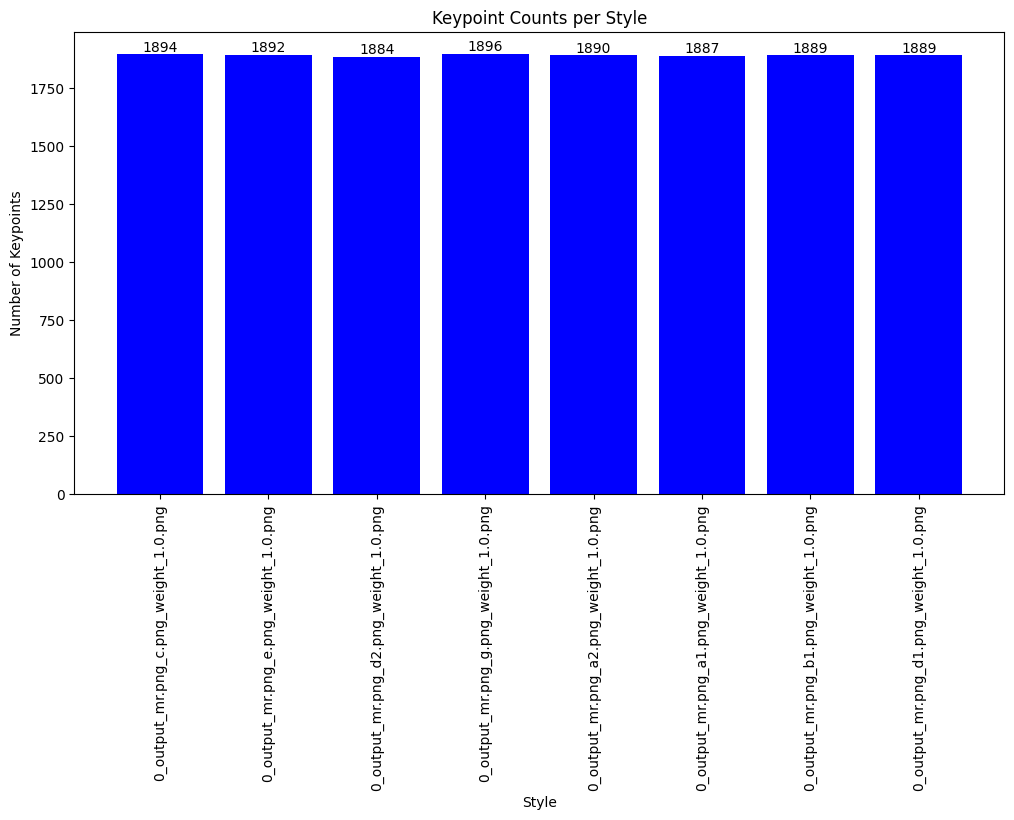

In [26]:
import matplotlib.pyplot as plt

def plot_keypoints_bar_chart(keypoints_dict):
    # Extracting style names and counts of keypoints
    styles = list(keypoints_dict.keys())
    counts = [len(keypoints_dict[style]) for style in styles]

    # Plotting
    plt.figure(figsize=(12, 6))
    bars = plt.bar(styles, counts, color='blue')

    # Adding count labels on top of each bar
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval, int(yval), ha='center', va='bottom')

    plt.xlabel('Style')
    plt.ylabel('Number of Keypoints')
    plt.title('Keypoint Counts per Style')
    plt.xticks(rotation=90)
    plt.show()

plot_keypoints_bar_chart(style_keypoints)


In [27]:
import numpy as np

def is_keypoint_in_list(style_keypoints, r_kp, margin):
    style_kps_array = np.array(style_keypoints)

    # Compute the absolute difference
    diff = np.abs(style_kps_array - r_kp.cpu().numpy())

    # Check if any keypoint is within the margin
    return np.any(np.all(diff <= margin, axis=1))

def find_consistent_keypoints(reference_keypoints, all_style_keypoints, margin=0):
    consistent_keypoints = []

    for r_kp in reference_keypoints:
        if all(is_keypoint_in_list(style_kps, r_kp, margin) for style_kps in all_style_keypoints.values()):
            consistent_keypoints.append(r_kp)
    
    return consistent_keypoints


# Use the keypoints from the most matched style to check consistency over all styles
consistent_keypoints = find_consistent_keypoints(anchor_keypoints, style_keypoints, margin=0)

print("Number of consistent keypoints across all styles:", len(consistent_keypoints))

Number of consistent keypoints across all styles: 1857


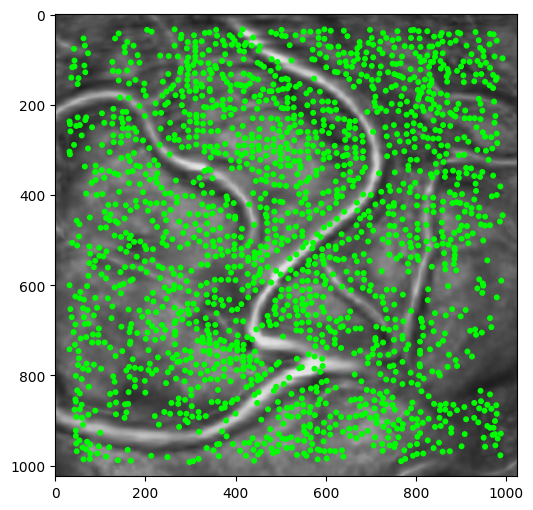

In [28]:
def match_consistent_keypoints(image1, consistent_keypoints, patch_size=64):
    # Preprocess and extract patches from both images
    image1 = image1.to(device)

    fig, axs = plt.subplots(1, 1, figsize=(6, 6))

    # Convert images to displayable format
    image1_np = image1.cpu().numpy().transpose(1, 2, 0)

    # Display original images
    
    axs.imshow(image1_np)

    # Overlay patches on images
    for i in range(len(consistent_keypoints)):
        x1, y1 = consistent_keypoints[i]
        color = 'lime'
        cir1 = patches.Circle((x1, y1), 5, linewidth=1, edgecolor=color, facecolor=color, alpha=1)
        axs.add_patch(cir1)

    plt.show()

match_consistent_keypoints(image1, consistent_keypoints)

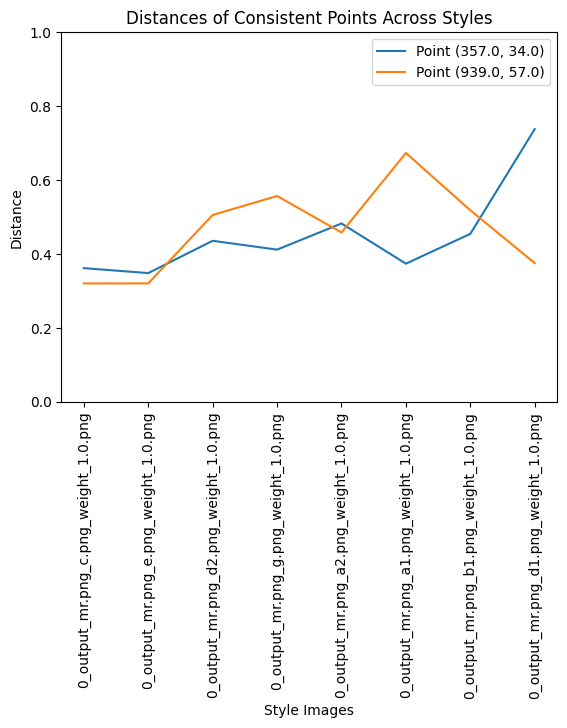

In [29]:
def plot_dist_of_consistent_points(anchor_image, styles_folder, consistent_points, device):

    # point_index = 0
    style_distances = {}
    
    for style_image_name in os.listdir(styles_folder):
        style_image_path = os.path.join(styles_folder, style_image_name)
        style_image = load_image(style_image_path)

        anchor_image = anchor_image.to(device)
        style_image = style_image.to(device)

        patches1, kpts1 = extract_patches(anchor_image.cpu().numpy(), consistent_points, size=patch_size)
        patches2, kpts2 = extract_patches(style_image.cpu().numpy(), consistent_points, size=patch_size)
    
        # Get embeddings for patches from both images
        embeddings1 = get_embeddings(patches1)
        embeddings2 = get_embeddings(patches2)

        # Convert embeddings to NumPy arrays for efficient computation
        embeddings1_array = np.array(embeddings1)
        embeddings2_array = np.array(embeddings2)

        # Compute pairwise distances between embeddings
        distances = np.linalg.norm(embeddings1_array[:, np.newaxis] - embeddings2_array, axis=2)
        style_distances[style_image_name] = np.min(distances, axis=1)

    return style_distances

def plot_style_distances(style_distances, consistent_points):
    # Prepare data for plotting
    styles = list(style_distances.keys())
    distances = [style_distances[style] for style in styles]
        
    # Plotting each point's distance across styles
    for i in range(len(distances[:2])):
        point_x, point_y = consistent_points[i]
        plt.plot(styles, [dist[i] for dist in distances], label=f'Point ({point_x}, {point_y})')

    plt.xlabel('Style Images')
    plt.ylabel('Distance')
    plt.title('Distances of Consistent Points Across Styles')
    plt.legend()
    plt.xticks(rotation=90)

    plt.ylim(0,1)
    
    # plt.tight_layout()
    # plt.show()
    plt.savefig("dist_lightglue_ours.png")

# Example usage
anchor_image = load_image('data/0_output_mr.png')
styles_folder = 'data/vrmr_guided/testset/0_output_mr'
style_distances = plot_dist_of_consistent_points(anchor_image, styles_folder, consistent_keypoints, device)

plot_style_distances(style_distances, consistent_keypoints)

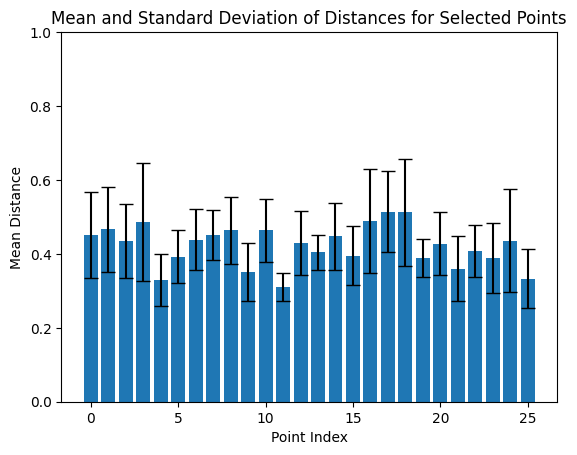

In [30]:
import numpy as np

mean_distances = {}
std_distances = {}

for point_index in range(len(consistent_keypoints)):
    point_distances = np.array([style_distances[style][point_index] for style in style_distances.keys()])
    mean_distances[point_index] = np.mean(point_distances)
    std_distances[point_index] = np.std(point_distances)

selected_points = [0, 1, 2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25]  # Replace with indices of points you want to plot
selected_means = [mean_distances[i] for i in selected_points]
selected_stds = [std_distances[i] for i in selected_points]

plt.bar(range(len(selected_points)), selected_means, yerr=selected_stds, capsize=5)
plt.xlabel('Point Index')
plt.ylabel('Mean Distance')
plt.title('Mean and Standard Deviation of Distances for Selected Points')
# plt.xticks(range(len(selected_points)), [f'Point {i}' for i in selected_points])

plt.ylim(0,1)

plt.savefig("stdmean_lightglue_ours.png")

plt.show()

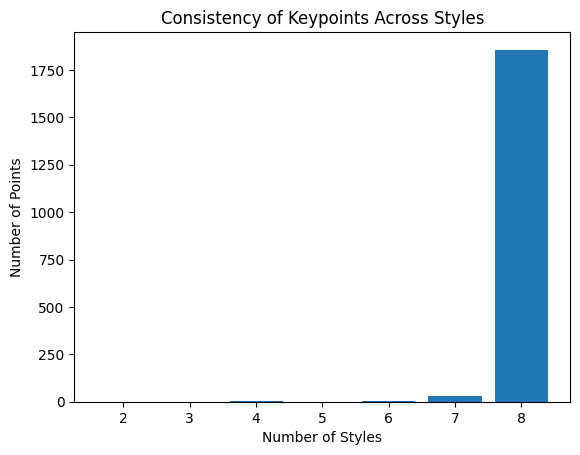

In [31]:
import matplotlib.pyplot as plt
import json

def find_consistency_counts(reference_keypoints, all_style_keypoints, margin=0):
    consistency_counts = {}

    for r_kp in reference_keypoints:
        count = sum(is_keypoint_in_list(style_kps, r_kp, margin) for style_kps in all_style_keypoints.values())
        if count > 0:
            count_int = int(count)
            consistency_counts.setdefault(count_int, 0)
            consistency_counts[count_int] += 1

    return consistency_counts

# Calculate consistency counts
consistency_counts = find_consistency_counts(anchor_keypoints, style_keypoints, margin=0)

# Save the consistency_counts to a JSON file
file_path = 'lightglue_ours_consistency_counts.json'
with open(file_path, 'w') as file:
    json.dump(consistency_counts, file)

# Plotting the consistency counts
style_counts = list(consistency_counts.keys())
num_points = list(consistency_counts.values())

plt.bar(style_counts, num_points)
plt.xlabel('Number of Styles')
plt.ylabel('Number of Points')
plt.title('Consistency of Keypoints Across Styles')
plt.xticks(style_counts)  # Ensure that all style counts are shown as x-ticks
plt.savefig('lightglue_ours_consistency_kp_count.png')
plt.show()

In [ ]:
def aggregate_counts(consistency_counts):
    aggregated_counts = {}
    max_count = max(consistency_counts.keys())
    min_count = min(consistency_counts.keys())

    cumulative_count = 0
    for count in range(max_count, min_count - 1, -1):
        cumulative_count += consistency_counts.get(count, 0)
        aggregated_counts[count] = cumulative_count

    return aggregated_counts

# Aggregate consistency counts
aggregated_counts = aggregate_counts(consistency_counts)

# Prepare the data for plotting
min_count = min(aggregated_counts.keys())
max_count = max(aggregated_counts.keys())
style_counts = list(range(min_count, max_count + 1))
num_points = [aggregated_counts.get(count, aggregated_counts[min_count]) for count in style_counts]

plt.bar(style_counts, num_points)
plt.xlabel('Number of Styles (or more)')
plt.ylabel('Number of Points')
plt.title('Aggregated Consistency of Keypoints Across Styles')
plt.xticks(style_counts)  # Ensure that all style counts are shown as x-ticks
plt.savefig('lightglue_ours_aggr_consistency_kp_count.png')
plt.show()

In [ ]:
import torch
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image
import requests
from torch.nn.functional import cosine_similarity

# Load a pre-trained VGG model
vgg = models.vgg16(pretrained=True).features

# Function to preprocess the image
def preprocess_image(img_path):
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

    image = Image.open(img_path).convert('RGB')
    return transform(image).unsqueeze(0)

# Function to calculate the Gram matrix
def gram_matrix(y):
    (b, ch, h, w) = y.size()
    features = y.view(b, ch, w * h)
    features_t = features.transpose(1, 2)
    gram = features.bmm(features_t) / (ch * h * w)
    return gram

# Function to extract feature maps and compute Gram matrix
def get_gram_matrix(image_path):
    image = preprocess_image(image_path)
    features = vgg(image)
    return gram_matrix(features)

# URLs of two images
image1_path = "data/0_output_mr.png"
image2_path = "data/vrmr_guided/0_output_mr/0_output_mr.png_style01.png_weight_1.0.png"

# Calculate Gram matrices
gram_matrix1 = get_gram_matrix(image1_path)
gram_matrix2 = get_gram_matrix(image2_path)

# Compare the Gram matrices using cosine similarity
similarity = cosine_similarity(gram_matrix1.view(1, -1), gram_matrix2.view(1, -1))

similarity.item()

In [ ]:
import os
import cv2
import matplotlib.pyplot as plt

def get_keypoints(image_path):
    image = cv2.imread(image_path)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    orb = cv2.ORB_create()
    keypoints, _ = orb.detectAndCompute(gray, None)
    return len(keypoints)

# Directory containing stylized images
image_directory = "data/vrmr_guided/0_output_mr"

# Initialize lists to store results
gram_scores = []
keypoint_counts = []

# Iterate over each image in the directory
for image_name in os.listdir(image_directory):
    image_path = os.path.join(image_directory, image_name)

    # Skip if it's not an image
    if not image_path.lower().endswith(('.png', '.jpg', '.jpeg')):
        continue

    # Calculate Gram matrix and similarity score
    gram_matrix_stylized = get_gram_matrix(image_path)
    similarity = cosine_similarity(gram_matrix1.view(1, -1), gram_matrix_stylized.view(1, -1))
    gram_scores.append(similarity.item())

    # Get the number of keypoints
    # keypoint_count = get_keypoints(image_path)
    keypoint_count = len(style_keypoints[image_name])
    keypoint_counts.append(keypoint_count)

# Plotting
plt.scatter(gram_scores, keypoint_counts)
plt.xlabel('Gram Score')
plt.ylabel('Number of Keypoints')
plt.yticks([0,400,800,1200,1600,2000])
plt.title('Gram Score vs Keypoints in Stylized Images')
plt.savefig('lightglue_ours_gram_score_keypoints.png')
plt.show()